#### Equity Portfolio Management

In [14]:
library('dplyr')
library('stringr')
library('reshape2')
library('purrr')
library('tidyverse')

#set theme of ggplot
theme_set(theme_gray(base_size = 14))
# set width and height of plot
options(repr.plot.width=11, repr.plot.height=7)

In [15]:
#reading data from all files

tks = c('IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN', 'FB', 'NFLX', 'TSLA', 'ORCL', 'SAP')


read.data = function(){
    for(i in 1:length(tks)){
        file.path = paste("./",tks[i],".csv", sep = "")
        assign(tks[i],read.csv(file.path, header = TRUE),.GlobalEnv)
        
    }}
read.data()


data.equity = data.frame(date = IBM$Date,IBM$Close,IBM$Adj.Close,MSFT$Close,MSFT$Adj.Close,GOOG$Close,GOOG$Adj.Close,AAPL$Close,AAPL$Adj.Close,
                        AMZN$Close,AMZN$Adj.Close,FB$Close,FB$Adj.Close,NFLX$Close,NFLX$Adj.Close,TSLA$Close,TSLA$Adj.Close,
                        ORCL$Close,ORCL$Adj.Close,SAP$Close,SAP$Adj.Close)
head(data.equity)

,date,IBM.Close,IBM.Adj.Close,MSFT.Close,MSFT.Adj.Close,GOOG.Close,GOOG.Adj.Close,AAPL.Close,AAPL.Adj.Close,AMZN.Close,...,FB.Close,FB.Adj.Close,NFLX.Close,NFLX.Adj.Close,TSLA.Close,TSLA.Adj.Close,ORCL.Close,ORCL.Adj.Close,SAP.Close,SAP.Adj.Close
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-01-02,154.25,135.7438,85.95,82.59932,1065.00,1065.00,43.0650,41.51358,1189.01,...,181.42,181.42,201.07,201.07,64.106,64.106,46.63,44.34246,112.39,107.6534
2,2018-01-03,158.49,139.4751,86.35,82.98373,1082.48,1082.48,43.0575,41.50634,1204.20,...,184.67,184.67,205.05,205.05,63.450,63.450,47.71,45.36948,113.31,108.5347
3,2018-01-04,161.70,142.3000,87.11,83.71412,1086.40,1086.40,43.2575,41.69914,1209.59,...,184.33,184.33,205.63,205.63,62.924,62.924,48.18,45.81642,115.05,110.2013
4,2018-01-05,162.49,142.9952,88.19,84.75201,1102.23,1102.23,43.7500,42.17389,1229.14,...,186.85,186.85,209.99,209.99,63.316,63.316,48.47,46.09220,116.33,111.4274
5,2018-01-08,163.47,143.8576,88.28,84.83849,1106.94,1106.94,43.5875,42.01725,1246.87,...,188.28,188.28,212.05,212.05,67.282,67.282,48.98,46.57718,114.80,109.9619
6,2018-01-09,163.83,144.1744,88.22,84.78084,1106.26,1106.26,43.5825,42.01243,1252.70,...,187.87,187.87,209.31,209.31,66.738,66.738,49.06,46.83493,114.16,109.3488


In [16]:
#computing dividend
#function to calculate dividends
calculate.dividend = function(company.name){
    
    data = get(company.name)
    divs = mutate(data,Dividend = (lag(Close)/Close - lag(Adj.Close)/Adj.Close)*Close)[c("Date","Dividend")] %>% mutate(Dividend = round(Dividend,2)) %>% filter(Dividend > 0)
    assign(paste(company.name,".divs", sep = ""),divs,.GlobalEnv)
}

#mapping function to all dataframes
companies = c('IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN', 'FB', 'NFLX', 'TSLA', 'ORCL', 'SAP')
d = map(companies,calculate.dividend)

dividends = rbind(IBM.divs,MSFT.divs,GOOG.divs,AAPL.divs,AMZN.divs,FB.divs,NFLX.divs,TSLA.divs,ORCL.divs,SAP.divs)
reps = map(list(IBM.divs,MSFT.divs,GOOG.divs,AAPL.divs,AMZN.divs,FB.divs,NFLX.divs,TSLA.divs,ORCL.divs,SAP.divs),nrow)
dividends$Company = rep(companies, times = c(unlist(reps)))

#order dividends accirding to company
with(dividends,dividends[order(Company),])

,Date,Dividend,Company
,<chr>,<dbl>,<chr>
9,2018-02-09,0.16,AAPL
10,2018-05-11,0.18,AAPL
11,2018-08-10,0.18,AAPL
12,2018-11-08,0.18,AAPL
1,2018-02-08,1.50,IBM
2,2018-05-09,1.57,IBM
3,2018-08-09,1.57,IBM
4,2018-11-08,1.57,IBM
5,2018-02-14,0.42,MSFT


#### Selecting 5 stocks to trade, calculating MTM for trading strategy low and high, calculating high tech index 

In [17]:
#function to select stocks
selectstocks = function(select = 'low', n.day = 5){
    
    if(select == 'low'){decrease = FALSE}
    else if(select == 'high'){decrease = TRUE}
    
    #selecting companies for trading lows
    
    filter_val = seq(1,nrow(data.equity),n.day)
    data.rebalancing = select(data.equity[filter_val,],contains("Adj.Close"))
    data.lag = lag(data.rebalancing)
    data.rebalancing = (data.lag - data.rebalancing)/data.lag
    
    #returns the 5 companies with highest drop in values
    sorted_companies = apply(data.rebalancing,1,function(x) (names(sort(x, decreasing = decrease))))
    sorted_companies = lapply(sorted_companies,function(x) str_remove_all(x,"Adj."))
    sorted_companies = rapply(lapply(sorted_companies,function(x) str_split(x, " ")[1:5]),function(x)x, how = 'unlist')


    #dataframe of companies with highest drop at each point in time
    inv_companies = c(c("IBM.Close", "MSFT.Close", "GOOG.Close", "AAPL.Close", "AMZN.Close"),str_split(sorted_companies," "))
    inv_companies = matrix(inv_companies, ncol = 5, byrow = TRUE)
    

    rows = c(rep(seq(1,nrow(inv_companies)-1), each = n.day),rep(nrow(inv_companies),nrow(data.equity)-(nrow(inv_companies)- 1)*n.day))
    data.equitymtm = data.frame(apply(inv_companies[rows,],2,as.character))
    colnames(data.equitymtm) = c('Inv.Comp1','Inv.Comp2','Inv.Comp3','Inv.Comp4','Inv.Comp5')
    data.equitymtm$date = data.equity$date
    
    return(data.equitymtm)
}
data.equitylow = selectstocks(select = 'low')
data.equityhigh = selectstocks(select = 'high')

In [18]:
#computing MTM
daily.mtm = function(data.equitycompanies, n.day = 5){
    
    cash = 5000000
    portfolio = cash
    mtm = c()
    dividend_stock = c()
    
    for(day in seq(1,nrow(data.equity))){
        if (day %% n.day == 1){
            
            if (day > n.day){
                
                sell.return = sum(n.shares*data.equity[day,unlist(data.equitycompanies[day-1,-6])])
                portfolio = sell.return + cash    
        }
        
        share_stock = portfolio/5
        n.shares = floor(share_stock / data.equity[day,unlist(data.equitycompanies[day,-6])])
        cash = portfolio - sum(n.shares*data.equity[day,unlist(data.equitycompanies[day,-6])])
        stock_new = unlist(data.equitycompanies[day,-6])
    }else if(day%% n.day == 2){
        dividend_stock = c(unlist(map(stock_new,function(x)str_remove_all(x,".Close")))) # stocks qualifying for dividend
        n.dividend_stock = n.shares # number of stocks qualifying for dividend
    }
    if (length(dividend_stock) != 0){
        stocks_paying_dividend = dividends[dividends$Date == data.equity[day,"date"] & dividends$Company %in% dividend_stock,c("Dividend","Company")]
        
        if(nrow(stocks_paying_dividend) != 0){
            div = sum(n.dividend_stock[order(dividend_stock)][1:nrow(stocks_paying_dividend)]*stocks_paying_dividend[,"Dividend"])
            mtm[day] = mtm[day] + div
        }

        
    }
    
    mtm[day] = sum(n.shares*data.equity[day,unlist(data.equitycompanies[day,-6])]) + cash
}
return(mtm)}
                                      
mtmlow = daily.mtm(data.equitylow) 
mtmhigh = daily.mtm(data.equityhigh)

In [19]:
#computing high tech index
data.equity$mtmlow = mtmlow
data.equity$mtmhigh = mtmhigh

data.equity$hightechindex = rowMeans(data.equity[,c(seq(2,20,2))])

#hightechindex = data.equity %>% select(!contains(".Adj") & !contains("Date")) %>% rowMeans
head(data.equity)
#head(data.equitylow)
#head(data.equityhigh)

,date,IBM.Close,IBM.Adj.Close,MSFT.Close,MSFT.Adj.Close,GOOG.Close,GOOG.Adj.Close,AAPL.Close,AAPL.Adj.Close,AMZN.Close,...,NFLX.Adj.Close,TSLA.Close,TSLA.Adj.Close,ORCL.Close,ORCL.Adj.Close,SAP.Close,SAP.Adj.Close,mtmlow,mtmhigh,hightechindex
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-01-02,154.25,135.7438,85.95,82.59932,1065.00,1065.00,43.0650,41.51358,1189.01,...,201.07,64.106,64.106,46.63,44.34246,112.39,107.6534,5000000,5000000,314.2891
2,2018-01-03,158.49,139.4751,86.35,82.98373,1082.48,1082.48,43.0575,41.50634,1204.20,...,205.05,63.450,63.450,47.71,45.36948,113.31,108.5347,5061134,5061134,318.8767
3,2018-01-04,161.70,142.3000,87.11,83.71412,1086.40,1086.40,43.2575,41.69914,1209.59,...,205.63,62.924,62.924,48.18,45.81642,115.05,110.2013,5103637,5103637,320.4171
4,2018-01-05,162.49,142.9952,88.19,84.75201,1102.23,1102.23,43.7500,42.17389,1229.14,...,209.99,63.316,63.316,48.47,46.09220,116.33,111.4274,5164049,5164049,325.0756
5,2018-01-08,163.47,143.8576,88.28,84.83849,1106.94,1106.94,43.5875,42.01725,1246.87,...,212.05,67.282,67.282,48.98,46.57718,114.80,109.9619,5187004,5187004,328.0539
6,2018-01-09,163.83,144.1744,88.22,84.78084,1106.26,1106.26,43.5825,42.01243,1252.70,...,209.31,66.738,66.738,49.06,46.83493,114.16,109.3488,5192788,5192788,328.1730


#### Plot of MTM vs high tech for both trading strategies 

In [20]:
perchange = data.equity %>% select(mtmhigh,mtmlow,hightechindex,date) %>% 
transmute(mtmhigh.perchg = (mtmhigh-mtmhigh[1])/mtmhigh[1], mtmlow.perchg = (mtmlow - mtmlow[1])/mtmlow[1], hightechindex.perchg = (hightechindex - hightechindex[1])/hightechindex[1],
         date = date)
perchange$day = seq(1,nrow(data.equity))

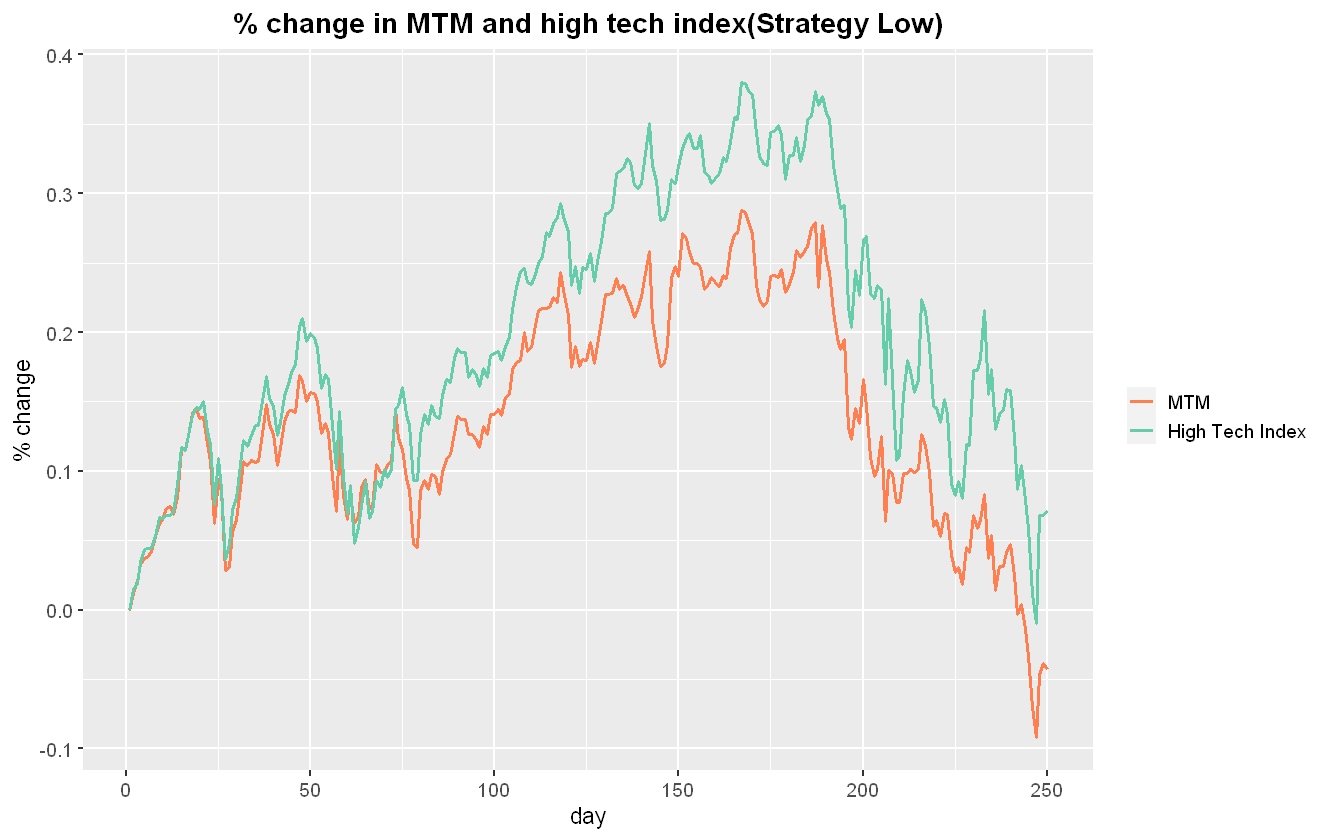

In [21]:
#plot MTM strategy low and high tech index
mtmlowplot = perchange %>% select(day,mtmlow.perchg,hightechindex.perchg) %>% melt(id.vars = 'day')

ggplot(mtmlowplot, aes(x = day))+geom_line(aes(y = value, color = variable), size = 1)+
ylab("% change")+ggtitle("% change in MTM and high tech index(Strategy Low)")+theme(plot.title = element_text(hjust = 0.5, face = "bold"),legend.title = element_blank())+scale_color_manual(labels = c("MTM", "High Tech Index"),
values = c('coral','aquamarine3'))

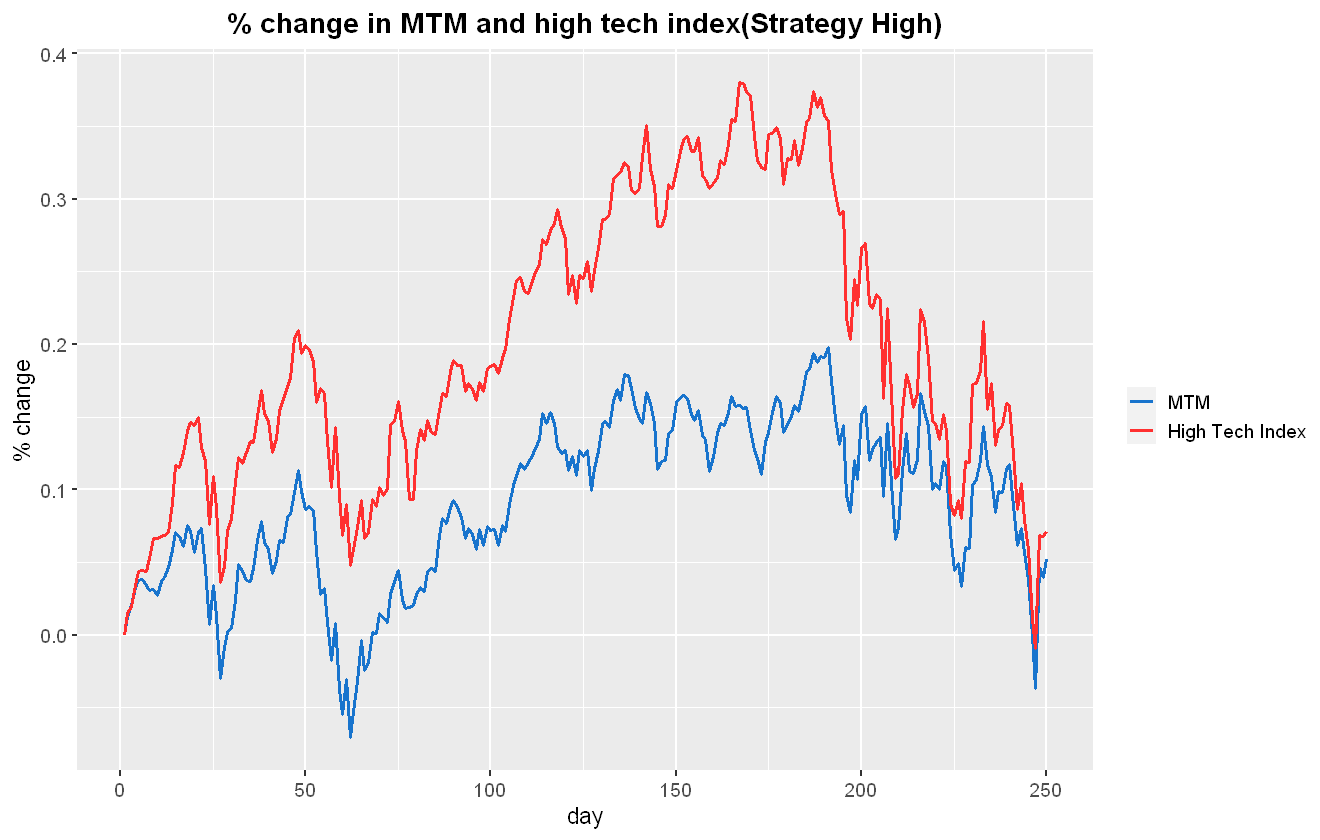

In [22]:
#plot MTM for high strategy and high tech index

mtmhighplot = perchange %>% select(day,mtmhigh.perchg,hightechindex.perchg) %>% melt(id.vars = 'day')

ggplot(mtmhighplot, aes(x = day))+geom_line(aes(y = value, color = variable), size = 1)+
ylab("% change")+ggtitle("% change in MTM and high tech index(Strategy High)")+theme(plot.title = element_text(hjust = 0.5, face = "bold"), legend.title = element_blank())+scale_color_manual(labels = c("MTM", "High Tech Index"), values = c("dodgerblue3", "firebrick1"))

#### Plot of MTM(USD) and MTM(JPY) for both trading strategies

In [23]:
data.usdjpy = read.csv("./USD_JPY_2018.csv")
colnames(data.usdjpy)[1] = "date" 

data.equity$date = as.Date(data.equity$date)
data.usdjpy$date = as.Date(data.usdjpy$date,"%m/%d/%Y")

data.mtmjpy = data.equity %>% select(date,mtmhigh,mtmlow) %>% inner_join(select(data.usdjpy,date,Close), by = c("date" = "date")) %>% mutate(mtmlow.jpy = mtmlow*Close, mtmhigh.jpy = mtmhigh*Close)
perchange = perchange %>% mutate(mtmlowjpy.perchg = (data.mtmjpy$mtmlow.jpy - data.mtmjpy$mtmlow.jpy[1])/data.mtmjpy$mtmlow.jpy[1], mtmhighjpy.perchg = (data.mtmjpy$mtmhigh.jpy - data.mtmjpy$mtmhigh.jpy[1])/data.mtmjpy$mtmhigh.jpy[1])

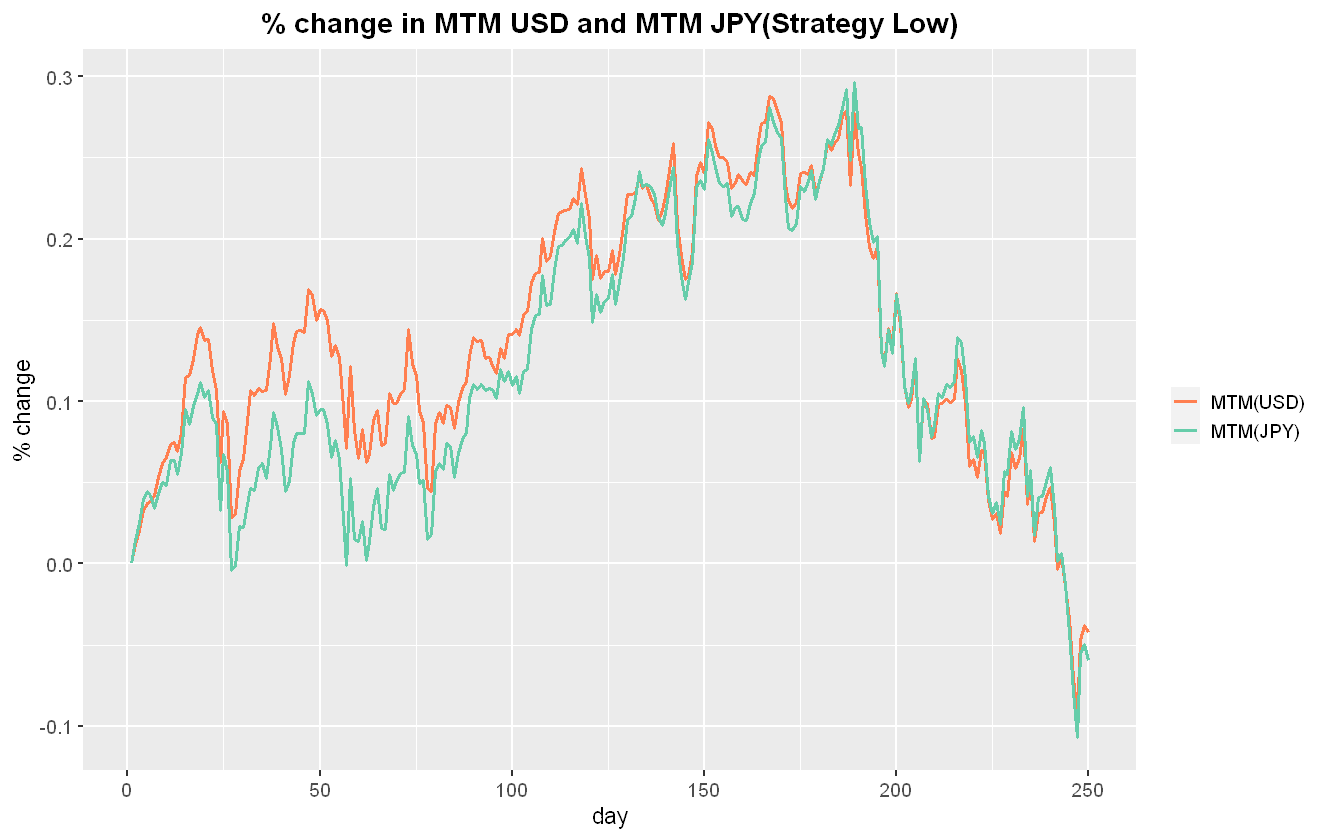

In [24]:
#plot of mtmlow and mtmlow.jpy

perchange %>% select(day,mtmlow.perchg,mtmlowjpy.perchg) %>% melt(id.vars = c('day')) %>% ggplot(aes(x = day))+geom_line(aes(y = value, color = variable), size = 1)+
ylab("% change")+ggtitle("% change in MTM USD and MTM JPY(Strategy Low)")+theme(plot.title = element_text(hjust = 0.5, face = "bold"), legend.title = element_blank()) + scale_color_manual(labels = c("MTM(USD)", "MTM(JPY)"),
values = c('coral','aquamarine3'))

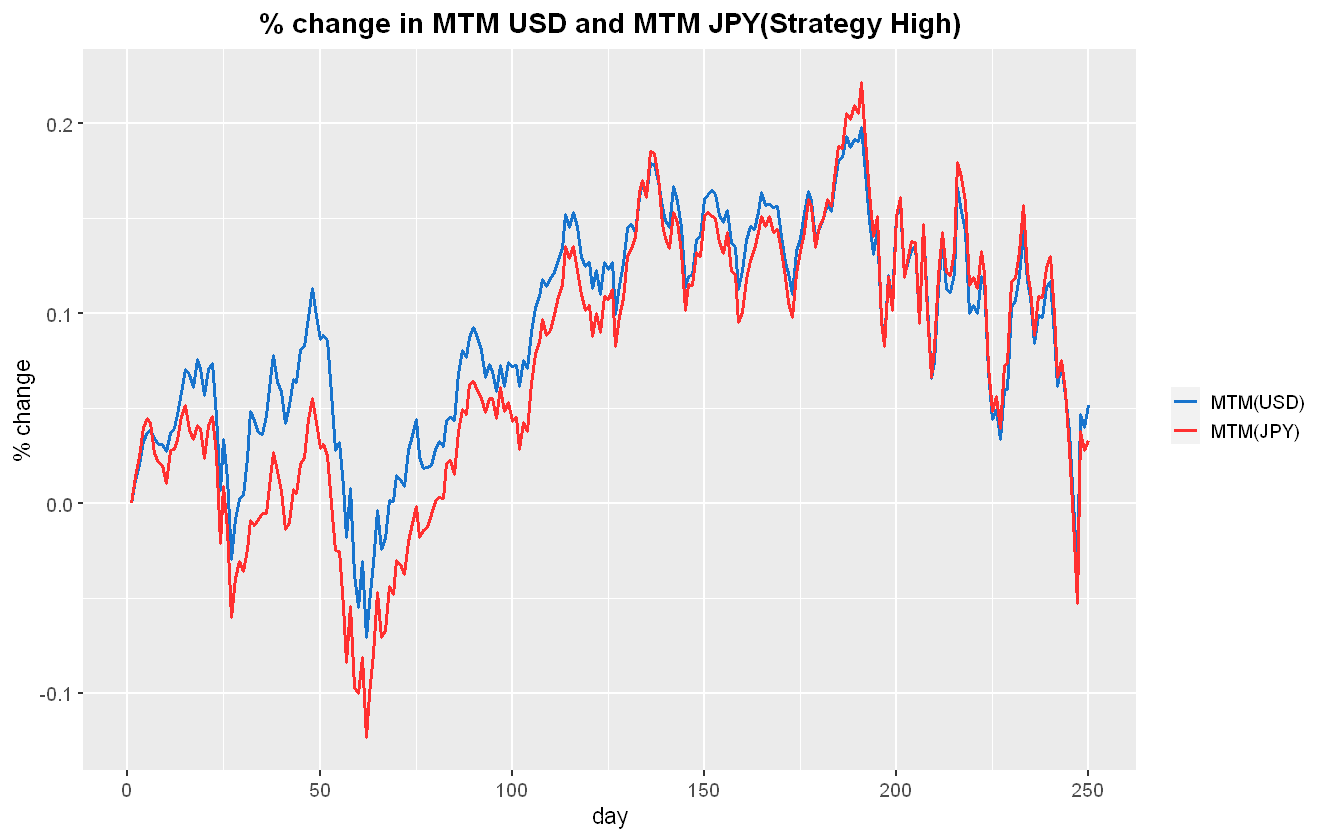

In [25]:
#plot of mtmhigh and mtmhighjpy
perchange %>% select(day,mtmhigh.perchg,mtmhighjpy.perchg) %>% melt(id.vars = c('day')) %>% ggplot(aes(x = day))+geom_line(aes(y = value, color = variable), size = 1)+
ylab("% change")+ggtitle("% change in MTM USD and MTM JPY(Strategy High)")+theme(plot.title = element_text(hjust = 0.5, face = "bold"), legend.title = element_blank())+scale_color_manual(labels = c("MTM(USD)", "MTM(JPY)"), values = c("dodgerblue3", "firebrick1"))

#### Checking optimal number of days for rebalancing

In [33]:
#used strategy trading when lows
reb.days = c(5,7,10,20)
days.mtm = c()
obs = length(data.equity)

for(day in reb.days){
    
    data.equitylow = selectstocks(select = 'low', n.day = day)
    mtmlow = daily.mtm(data.equitylow, n.day = day)
    days.mtm = append(days.mtm,mtmlow[obs]) 
}
cat("Rebalancing periods considered :",reb.days)
cat("\n")
cat("MTM for all periods :",days.mtm)
cat("\n")
cat("Optimal rebalacing period :",reb.days[which.max(days.mtm)])
cat("\n")
cat("Maximized MTM :",max(days.mtm))

Rebalancing periods considered : 5 7 10 20
MTM for all periods : 5313775 5371038 5392142 5126940
Optimal rebalacing period : 10
Maximized MTM : 5392142

MTM for strategy low maximizes when rebalancing happens every 10 days.